In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator


In [ ]:
research_data = pd.read_csv('/content/sample_data/usa_dataset.csv')
research_data.info

<bound method DataFrame.info of           dates  gasoline_price  crude_oil_Price
0    15-01-2001            1.47            29.59
1    15-02-2001            1.48            29.61
2    15-03-2001            1.41            27.25
3    15-04-2001            1.50            27.49
4    15-05-2001            1.71            28.63
..          ...             ...              ...
257  15-06-2022            5.01           114.84
258  15-07-2022            4.65           101.62
259  15-08-2022            3.94            93.67
260  15-09-2022            3.69            84.26
261  15-10-2022            3.91            87.55

[262 rows x 3 columns]>

In [ ]:
DFF = pd.read_csv('/content/sample_data/usa_dataset.csv')
DFF['dates'] = pd.to_datetime(DFF['dates'], format='%d-%m-%Y')
DF2=DFF
DF2.index= pd.to_datetime(DFF.dates)
DF2= DF2['gasoline_price']['01-01-2001':'01-10-2022']

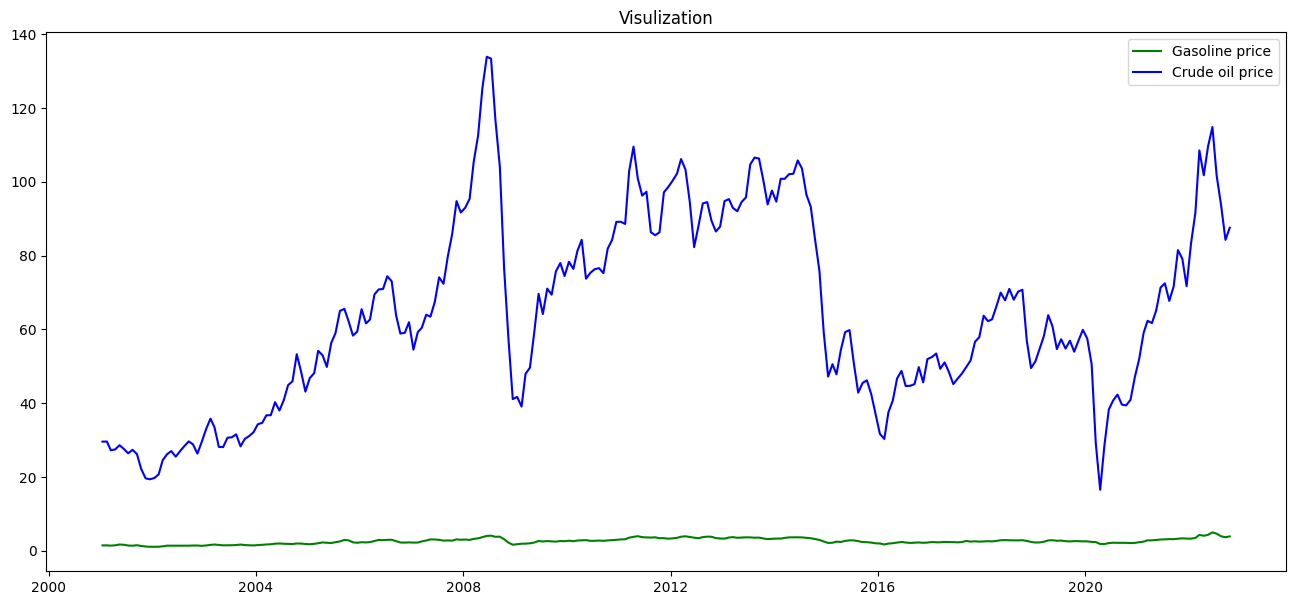

In [ ]:
gasoline=DFF['gasoline_price']
crude=DFF['crude_oil_Price']

plt.figure(figsize=(16,7))
fig=plt.figure(1)

std=plt.plot(gasoline,color='green',label='Gasoline price')
orig1=plt.plot(crude,color='blue',label='Crude oil price')


plt.legend(loc='best')
plt.title('Visulization')
plt.show(block=False)

In [ ]:
lstm_data = research_data[['dates','crude_oil_Price', 'gasoline_price']]
lstm_data = lstm_data.set_index('dates')


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(lstm_data)
lstm_data_scaled = scaler.transform(lstm_data)
lstm_data_scaled_df = pd.DataFrame(lstm_data_scaled, index = lstm_data.index, columns = lstm_data.columns)


In [ ]:
lstm_data_scaled_df

,crude_oil_Price,gasoline_price
dates,,
15-01-2001,-1.332578,-1.500970
15-02-2001,-1.331799,-1.487893
15-03-2001,-1.423667,-1.579436
15-04-2001,-1.414324,-1.461738
15-05-2001,-1.369948,-1.187110
...,...,...
15-06-2022,1.985937,3.128473
15-07-2022,1.471324,2.657682
15-08-2022,1.161855,1.729178


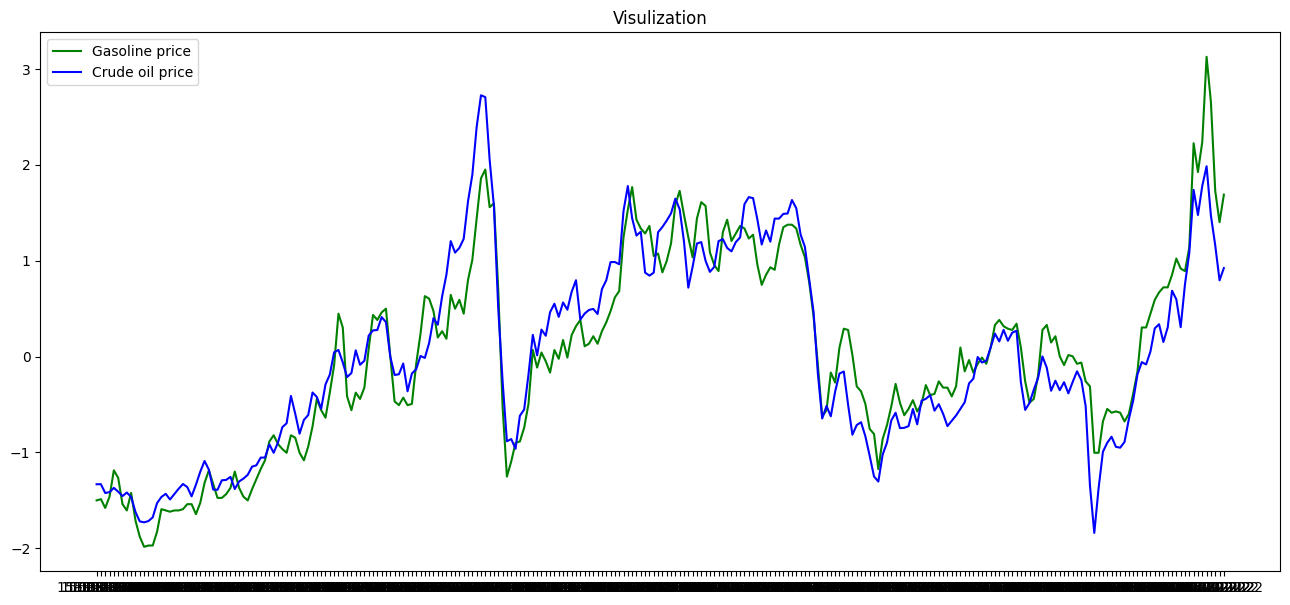

In [ ]:
gasoline=lstm_data_scaled_df['gasoline_price']
crude=lstm_data_scaled_df['crude_oil_Price']

plt.figure(figsize=(16,7))
fig=plt.figure(1)

std=plt.plot(gasoline,color='green',label='Gasoline price')
orig1=plt.plot(crude,color='blue',label='Crude oil price')


plt.legend(loc='best')
plt.title('Visulization')
plt.show(block=False)

In [ ]:
train_lstm = lstm_data_scaled_df[:int(0.96*(len(lstm_data_scaled_df)))]
test_lstm = lstm_data[int(0.96*(len(lstm_data))):]


In [ ]:
lstm_training_transformed_df = train_lstm.diff().dropna()

In [ ]:
lstm_training_transformed = lstm_training_transformed_df.to_numpy()

In [ ]:
test_lstm.shape

(11, 2)

In [ ]:
lstm_input = 2
lstm_columns = 3

In [ ]:
generatorTrain = TimeseriesGenerator(lstm_training_transformed, lstm_training_transformed, length = lstm_input, batch_size = 1)
generatorTest = TimeseriesGenerator(test_lstm, test_lstm, length = lstm_input, batch_size = 1)


In [ ]:
model = Sequential()
model.add(LSTM(50, activation = 'tanh', input_shape = (lstm_input, lstm_columns)))
model.add(Dense(lstm_columns))
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(generatorTrain, epochs = 10, batch_size = 48, shuffle = False)


In [ ]:
prediction_lstm = []
first_batch = lstm_training_transformed[-lstm_input:]
current_batch = first_batch.reshape((1, lstm_input, lstm_columns))


In [ ]:
for i in range(len(test_lstm)):
    current_pred = model.predict(current_batch)[0]
    prediction_lstm.append(current_pred)
    cbrf = current_batch[:, 1:, :]
    current_batch = np.append(cbrf, [[current_pred]], axis = 1)


1/1 [==============================] - 0s 15ms/step


In [ ]:
pred_data_df = pd.DataFrame(prediction_lstm, index = test_lstm.index, columns = test_lstm.columns + '_pred')


In [ ]:
def invert_transformation(df, pred):
    forecast = pred_data_df.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
inverted_pred_values = invert_transformation(lstm_training_transformed_df, pred_data_df)


In [ ]:
inverted_pred_values

,GOR_pred,crude_oil_Price_pred,gasoline_price_pred
dates,,,
15-12-2021,0.019361,-0.124215,0.150893
15-01-2022,0.033230,-0.132796,0.126168
15-02-2022,0.035231,-0.123634,0.132855
15-03-2022,0.037537,-0.111396,0.150786
15-04-2022,0.041834,-0.100091,0.168970
15-05-2022,0.046751,-0.089341,0.185841
15-06-2022,0.051641,-0.078597,0.202284
15-07-2022,0.056443,-0.067761,0.218789
15-08-2022,0.061221,-0.056888,0.235381


In [ ]:
unscaledData = scaler.inverse_transform(pred_data_df)
unscaledDataDF = pd.DataFrame(unscaledData, index = pred_data_df.index, columns = pred_data_df.columns)


In [ ]:
from sklearn.metrics import mean_squared_error
import math

rmse=math.sqrt(mean_squared_error(unscaledDataDF['gasoline_price_pred'], test_lstm['gasoline_price']))
print(rmse)

from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(unscaledDataDF['gasoline_price_pred'], test_lstm['gasoline_price'])
print(mape)

1.4731549636780636
0.5257986834173459


In [ ]:
result=pd.DataFrame()
result['gasoline_pred']=unscaledDataDF['gasoline_price_pred']
result['gasoline_actual']=test_lstm['gasoline_price']
result

,gasoline_pred,gasoline_actual
dates,,
15-12-2021,2.608094,3.32
15-01-2022,2.593720,3.30
15-02-2022,2.620537,3.49
15-03-2022,2.631078,4.32
15-04-2022,2.630872,4.09
15-05-2022,2.629371,4.33
15-06-2022,2.628987,5.01
15-07-2022,2.629128,4.65
15-08-2022,2.629238,3.94


(0.0, 8.0)

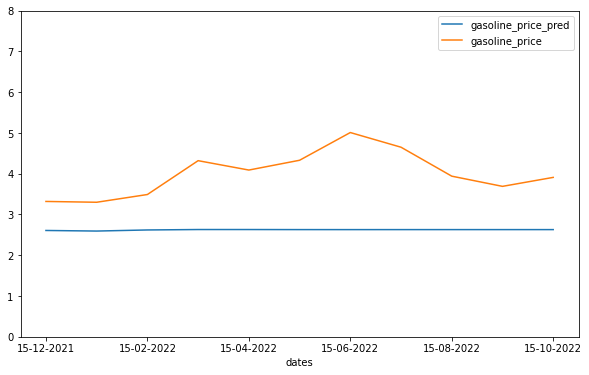

In [ ]:
plt.figure(figsize=(10, 6))
fig=plt.figure(1)
unscaledDataDF['gasoline_price_pred'].plot(legend=True)
test_lstm['gasoline_price'].plot(legend=True)
ax = plt.gca()
ax.set_ylim([0, 8])

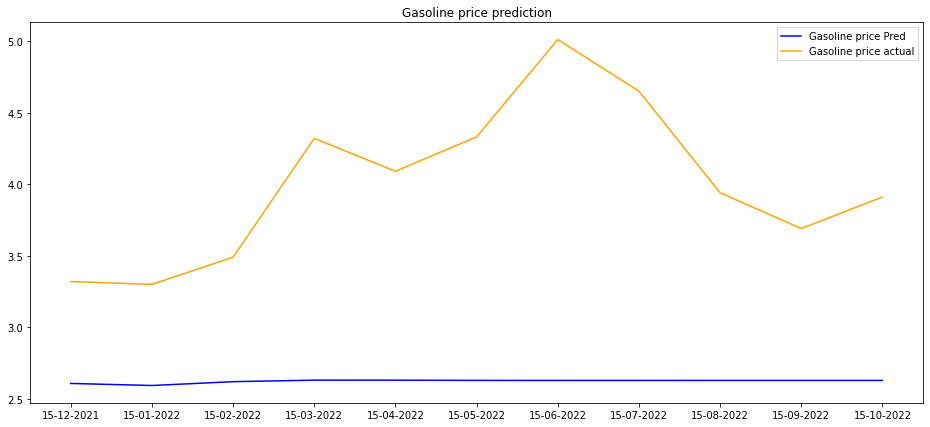

In [ ]:
unscalDF=result['gasoline_pred']
test_data=result['gasoline_actual']
plt.figure(figsize=(16,7))
fig=plt.figure(1)

std=plt.plot(unscalDF,color='blue',label='Gasoline price Pred')
std2=plt.plot(test_data,color='orange',label='Gasoline price actual')

plt.legend(loc='best')
plt.title('Gasoline price prediction')
plt.show(block=False)